Exercises and code samples for the course Unsupervised and Reinforcement Learning (AAI-URL) in the Bachelor of AAI at Rosenheim University of Applied Sciences.


Credits go to https://github.com/TanyaChutani/VAE-TF2.0

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

2023-12-11 09:17:13.084403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 09:17:13.118106: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 09:17:13.118574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 09:17:13.650189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading data

In [2]:
epochs=100
batch_size=50
input_shape=(64,64,1)
latent_dim=2
h_image,w_image=64,64


In [3]:
data=fetch_olivetti_faces()
images = data.images.reshape((data.images.shape[0],\
                                data.images.shape[1], data.images.shape[2]))
labels=(data.target)
X_train, X_test, y_train, y_test = train_test_split(images,
                                                  labels, test_size=0.01)


## Data Generator

In [4]:
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
batch(batch_size).repeat()

test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test)).\
batch(batch_size).repeat()

2023-12-11 09:17:28.652041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 09:17:28.665974: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Model 

In [5]:
def conv_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2D(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  
def conv_transpose_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2DTranspose(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  

def model(input_shape,latent_dim):
  #Encoder 
  model_input=tf.keras.Input(input_shape)
  layer=conv_layer(model_input,16,5,strides=2)
  layer=conv_layer(layer,32,3,strides=2)
  layer=conv_layer(layer,64,3,strides=2)
  layer=conv_layer(layer,128,3,strides=2)
  shape_before_flatten=layer.shape
  layer=tf.keras.layers.Flatten()(layer)
  mean=tf.keras.layers.Dense(latent_dim)(layer)
  var=tf.keras.layers.Dense(latent_dim)(layer)
  encoder_model=tf.keras.models.Model(model_input,[mean,var])
  
  #Decoder
  decoder_input=tf.keras.Input((latent_dim,))
  layer=tf.keras.layers.Dense(np.prod(shape_before_flatten[1:]),\
                              activation='relu')(decoder_input)
  layer=tf.keras.layers.Reshape(target_shape=shape_before_flatten[1:])(layer)
  layer=conv_transpose_layer(layer,128,3,strides=2)
  layer=conv_transpose_layer(layer,64,3,strides=2)
  layer=conv_transpose_layer(layer,32,3,strides=2)
  layer=conv_transpose_layer(layer,16,5,strides=2)
  layer=conv_transpose_layer(layer,1,3,activation='sigmoid')
  decoder_model=tf.keras.models.Model(decoder_input,layer)  
 
  #Reparameterization Trick
  mean,var=encoder_model(model_input)
  epsilon=tf.random.normal(shape=(tf.shape(var)[0],
                                  tf.shape(var)[1]))
  z=mean+tf.exp(var)*epsilon
  model_out=decoder_model(z)
  model=tf.keras.models.Model(model_input,model_out)
 
  #Reconstruction loss
  reconstruction_loss = K.sum(K.binary_crossentropy(model_input,
                                                    model_out), axis=[1, 2, 3])
  
  #KL div loss
  kl_loss = - 0.5 * K.sum(1 + var - K.square(mean) - K.exp(var), axis=-1)
  
  elbo = K.mean(reconstruction_loss + kl_loss)
  model.add_loss(elbo)

  return model,decoder_model,encoder_model

In [7]:
vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)

vae_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='./model_output/face_model.h5',
                                            patience=0, verbose=0))]
vae_model.fit(train_dataset,epochs=epochs,callbacks=callback,steps_per_epoch=\
              (len(X_train)//batch_size))

Epoch 1/100
7/7 [==============================] - 2s 115ms/step - loss: 2832.8079
Epoch 2/100
7/7 [==============================] - 1s 99ms/step - loss: 2824.4941
Epoch 3/100
7/7 [==============================] - 1s 91ms/step - loss: 2820.1780
Epoch 4/100
7/7 [==============================] - 1s 97ms/step - loss: 2818.5583
Epoch 5/100
7/7 [==============================] - 1s 87ms/step - loss: 2786.2661
Epoch 6/100
7/7 [==============================] - 1s 93ms/step - loss: 2764.8015
Epoch 7/100
7/7 [==============================] - 1s 95ms/step - loss: 2752.9753
Epoch 8/100
7/7 [==============================] - 1s 88ms/step - loss: 2746.2598
Epoch 9/100
7/7 [==============================] - 1s 100ms/step - loss: 2742.8394
Epoch 10/100
7/7 [==============================] - 1s 98ms/step - loss: 2739.8110
Epoch 11/100
7/7 [==============================] - 1s 91ms/step - loss: 2726.4370
Epoch 12/100
7/7 [==============================] - 1s 121ms/step - loss: 2737.0278
Epoch 13/1

7/7 [==============================] - 1s 88ms/step - loss: 2661.2954
Epoch 100/100
7/7 [==============================] - 1s 93ms/step - loss: 2668.7026


## Inference 

2023-12-11 09:19:35.812228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4]
	 [[{{node Placeholder/_1}}]]
2023-12-11 09:19:35.845797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4]
	 [[{{node Placeholder/_1}}]]
2023-12-11 09:19:35.864702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4]
	 [[{{node

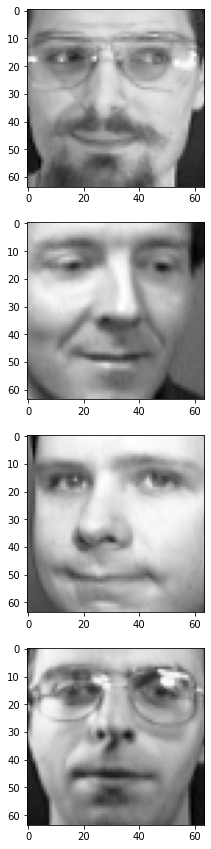

1/1 [==============================] - 0s 74ms/step


2023-12-11 09:19:36.158079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4]
	 [[{{node Placeholder/_1}}]]


ValueError: in user code:

    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/marcel/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>]


<Figure size 1080x1080 with 0 Axes>

In [8]:
#Testing using decoder

#Image generated 
plt.figure(figsize=(15,15))
img_size=(h_image,w_image)

for i in range(4):
   for val in test_dataset.take(1):
     plt.subplot(4,1,i+1)
     plt.imshow(tf.reshape(val[0][i],img_size),cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
for i in range(4):
  for val in test_dataset.take(1):
    z=encoder_model.predict(np.expand_dims(val[0][i],axis=0))
    output=decoder_model.predict(z)
    output=tf.reshape(output,img_size)
    plt.subplot(4,1,i+1)
    plt.imshow(output,cmap='gray')
plt.show()


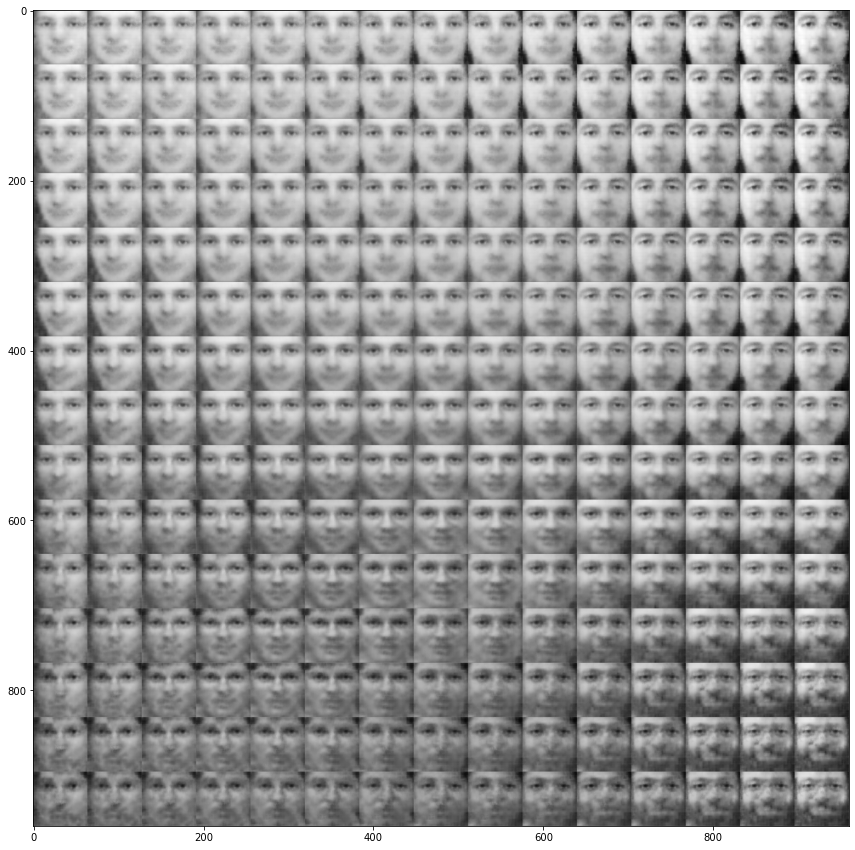

In [9]:
#Uniformally generated Data

plt.figure(figsize=(15,15))
size = 64
n = 15

save_images = np.zeros((size * n, size * n))

grid_x = tf.linspace(-1.5, 1.5, n)
grid_y = tf.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        img = decoder_model(z_sample)
        img = tf.reshape(img[0],img_size)
        save_images[i * size: (i + 1) * size, j * size: (j + 1) * size] = img

plt.imshow(save_images, cmap='gray')
plt.show()


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


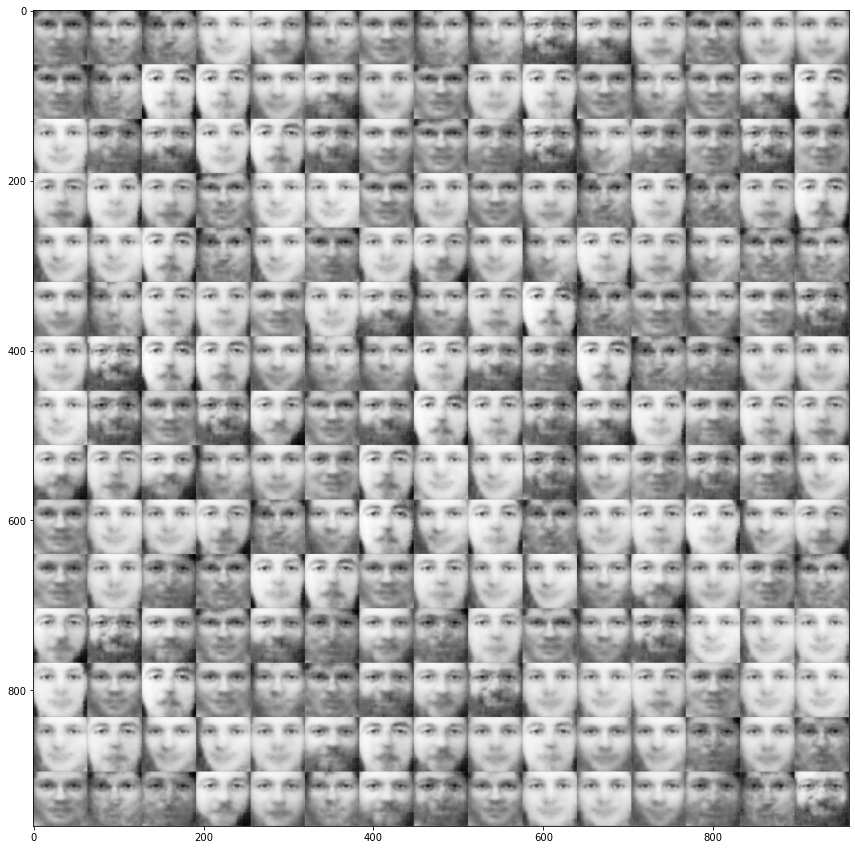

In [10]:
#Randomly Generated Data
n = 15
size = 64
save_images = np.zeros((size * n, size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1.5, 1.5,size=latent_dim)])
        x_decoded = decoder_model.predict(z_sample)
        img = tf.reshape(x_decoded[0],img_size)
        save_images[i * size: (i + 1) * size,j * size: (j + 1) * size] = img

plt.figure(figsize=(15, 15))
plt.imshow(save_images, cmap='Greys_r')
plt.show()
